In [3]:
from pathlib import Path

import geopandas as gpd
import pandas as pd
import numpy as np
import pdal

import xarray as xr
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

In [4]:
data_dir = Path("../data")
plots_lidar_dir = data_dir / "outputs" / "plots" / "lidar"
plots_gdf = gpd.read_file("../data/outputs/plots/plots.geojson")
plots = plots_gdf["id"].to_list()

In [5]:
def read_plot(plot_id: str):
    file_path = plots_lidar_dir / f"{plot_id}.copc.laz"
    pl = pdal.Reader(str(file_path)).pipeline()
    pl.execute()
    return pl.arrays[0]

In [ ]:
def create_z_binned_ds(
    z: np.ndarray,
    # TODO - add grain size, then same fn can do heights and voxels
    # or heights are just voxels with "infinite" grain size
    # x: np.ndarray | None = None,
    # y: np.ndarray | None = None,
    weights: np.ndarray | None = None,
    bin_size=1,
    k=0.5,
    suffix: str | None = None,
):
    if weights is None:
        weights = np.ones(len(z))

    total = weights.sum()

    ds = xr.Dataset(
        data_vars={
            "z":  ("idx", z),
            "weights": ("idx", weights)
        },
        coords={
            "idx": np.arange(len(z))
        },
        attrs={
            "total": total,
        }
    )

    z_bins = np.arange(-bin_size, z.max() + bin_size, bin_size)
    # z_labels = [f"({lower}, {upper}]" for lower, upper in zip(z_bins, z_bins[1:])]
    # z_labels[0] = '0'

    def calc_inside(sub_ds: xr.Dataset):
        print(sub_ds)

        return xr.Dataset({
            "inside": sub_ds['weights'].sum(),
            "%_inside": sub_ds['weights'].sum() / sub_ds.attrs['total'] * 100
        })

    binned_ds = ds.groupby(z=xr.groupers.BinGrouper(bins=z_bins,)).map(calc_inside)

    total_z = binned_ds['inside'].sum()
    # binned_ds['%_inside'] = binned_ds['inside'] / total_z

    binned_ds['entries'] = binned_ds['inside'].cumsum(dim='z_bins')
    # Quick way to calc exits is to shift entries up 1
    # i.e. exists of one slice is the same as the entries below
    binned_ds['exits'] = binned_ds['entries'].shift(z_bins=1)

    binned_ds['ppi'] = binned_ds['exits'] / binned_ds['entries']
    binned_ds['vad'] = - np.log(binned_ds['ppi']) * (1 / k) * (1 / bin_size)

    if suffix is not None:
        rename_dict = {var: f"{var}[{suffix}]" for var in binned_ds.data_vars}
        binned_ds = binned_ds.rename(rename_dict)

    return binned_ds
    

In [13]:
points = read_plot("AGG_O_01_P1")

In [14]:
z = points['Z']
rn = points['ReturnNumber']
weights = points['Weight']

fr = z[rn == 1]

height_profile = create_z_binned_ds(z)
height_profile_weighted = create_z_binned_ds(z, weights=weights, suffix='w')
height_profile_fr = create_z_binned_ds(fr, suffix='fr')
hp = xr.merge([height_profile, height_profile_weighted, height_profile_fr])
hp.head()

<xarray.Dataset> Size: 1MB
Dimensions:  (idx: 54548)
Coordinates:
  * idx      (idx) int64 436kB 0 1 2 3 4 ... 252172 252184 252249 252331 252468
Data variables:
    z        (idx) float64 436kB 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    weights  (idx) float64 436kB 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
Attributes:
    total:    252716.0
<xarray.Dataset> Size: 1MB
Dimensions:  (idx: 45574)
Coordinates:
  * idx      (idx) int64 365kB 53 54 68 74 75 ... 252707 252713 252714 252715
Data variables:
    z        (idx) float64 365kB 0.069 0.092 0.044 0.143 ... 0.622 0.574 0.314
    weights  (idx) float64 365kB 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
Attributes:
    total:    252716.0
<xarray.Dataset> Size: 160kB
Dimensions:  (idx: 6683)
Coordinates:
  * idx      (idx) int64 53kB 98 279 321 322 370 ... 252704 252706 252708 252711
Data variables:
    z        (idx) float64 53kB 1.92 1.332 1.16 1.49 ... 1.814 1.734 1.813 1.747
    weights  (idx) float64 53kB 1.0 1.0 1

<xarray.Dataset> Size: 800B
Dimensions:       (z_bins: 5)
Coordinates:
  * z_bins        (z_bins) interval[float64, right] 80B (-1.0, 0.0] ... (3.0,...
Data variables: (12/18)
    inside        (z_bins) float64 40B 5.455e+04 4.557e+04 ... 7.975e+03
    %_inside      (z_bins) float64 40B 0.2158 0.1803 0.02644 0.025 0.03156
    entries       (z_bins) float64 40B 5.455e+04 1.001e+05 ... 1.211e+05
    exits         (z_bins) float64 40B nan 5.455e+04 ... 1.068e+05 1.131e+05
    ppi           (z_bins) float64 40B nan 0.5448 0.9374 0.9441 0.9341
    vad           (z_bins) float64 40B nan 1.215 0.1292 0.115 0.1362
    ...            ...
    inside[fr]    (z_bins) float64 40B 1.149e+04 8.947e+03 ... 3.623e+03
    %_inside[fr]  (z_bins) float64 40B 0.08842 0.06886 0.01409 0.01806 0.02789
    entries[fr]   (z_bins) float64 40B 1.149e+04 2.044e+04 ... 2.824e+04
    exits[fr]     (z_bins) float64 40B nan 1.149e+04 ... 2.227e+04 2.461e+04
    ppi[fr]       (z_bins) float64 40B nan 0.5622 0.9178 0.9047 0.8717
    vad[fr]       (z_bins) float64 40B nan 1.152 0.1716 0.2003 0.2747

In [ ]:
def create_xyz_binned_ds(
    points: np.ndarray,
    weights: np.ndarray | None = None,
    grain_size=5,
    bin_size=1,
    k=0.5,
    suffix: str | None = None,
):
    if weights is None:
        weights = np.ones(len(z))

    total = weights.sum()

    ds = xr.Dataset(
        data_vars={
            "z":  ("idx", z),
            "weights": ("idx", weights)
        },
        coords={
            "idx": np.arange(len(z))
        },
    )

    z_bins = np.arange(-bin_size, z.max() + bin_size, bin_size)
    # z_labels = [f"({lower}, {upper}]" for lower, upper in zip(z_bins, z_bins[1:])]
    # z_labels[0] = '0'

    def calc_inside(sub_ds):
        
        return xr.Dataset({
            "inside": sub_ds['weights'].sum(),
        })

    binned_ds = ds.groupby(z=xr.groupers.BinGrouper(bins=z_bins,)).map(calc_inside)

    total_z = binned_ds['inside'].sum()
    binned_ds['%_inside'] = binned_ds['inside'] / total_z

    binned_ds['entries'] = binned_ds['inside'].cumsum(dim='z_bins')
    # Quick way to calc exits is to shift entries up 1
    # i.e. exists of one slice is the same as the entries below
    binned_ds['exits'] = binned_ds['entries'].shift(z_bins=1)

    binned_ds['ppi'] = binned_ds['exits'] / binned_ds['entries']
    binned_ds['vad'] = - np.log(binned_ds['ppi']) * (1 / k) * (1 / bin_size)

    if suffix is not None:
        rename_dict = {var: f"{var}[{suffix}]" for var in binned_ds.data_vars}
        binned_ds = binned_ds.rename(rename_dict)

    return binned_ds
    

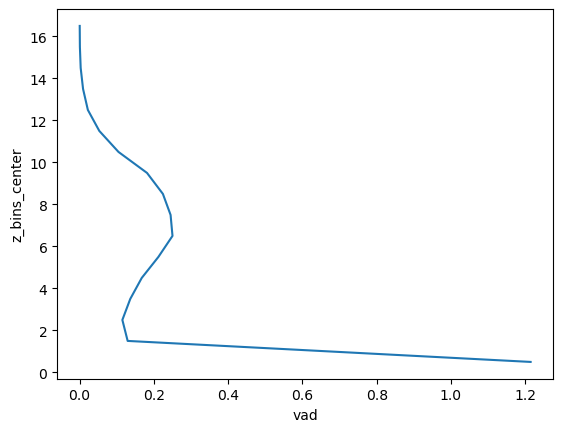

In [160]:
hp['vad'].plot(y='z_bins')